# Initial Analysis of Time Series

## First Option - Electricity consumption in Brazil - residential [1975-2025]

In [6]:
import pandas as pd
import requests

url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.1403/dados?formato=json"
response = requests.get(url)

if response.status_code == 200:
    # Converter para DataFrame
    data = pd.DataFrame(response.json())
    data["data"] = pd.to_datetime(data["data"], dayfirst=True)
    data["valor"] = data["valor"].astype(float) 

    
    print(data.head(10))
else:
    print("Erro ao acessar a API:", response.status_code)


        data   valor
0 1979-02-01  1647.0
1 1979-03-01  1736.0
2 1979-04-01  1681.0
3 1979-05-01  1757.0
4 1979-06-01  1689.0
5 1979-07-01  1730.0
6 1979-08-01  1697.0
7 1979-09-01  1809.0
8 1979-10-01  1789.0
9 1979-11-01  1840.0


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

data = data.sort_values("data")  # Sorting in ascending order
data.set_index("data", inplace=True)  # Confirm data as index for TS

stats = data["valor"].describe()
stats


count      552.000000
mean      7054.106884
std       3629.927195
min       1647.000000
25%       4033.000000
50%       6642.500000
75%      10285.500000
max      15637.000000
Name: valor, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


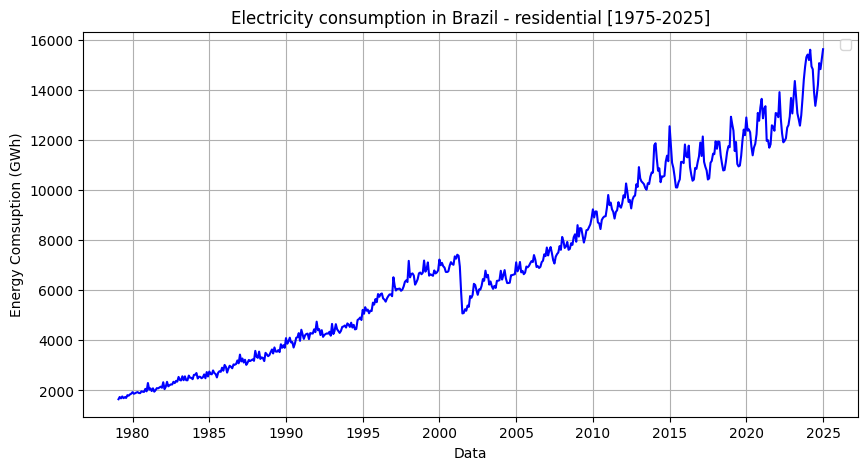

In [8]:
# TS Pre Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(data.index, data["valor"], color='blue')
plt.xlabel("Data")
plt.ylabel("Energy Comsuption (GWh)")
plt.title("Electricity consumption in Brazil - residential [1975-2025]")
plt.legend()
plt.grid()
plt.show()

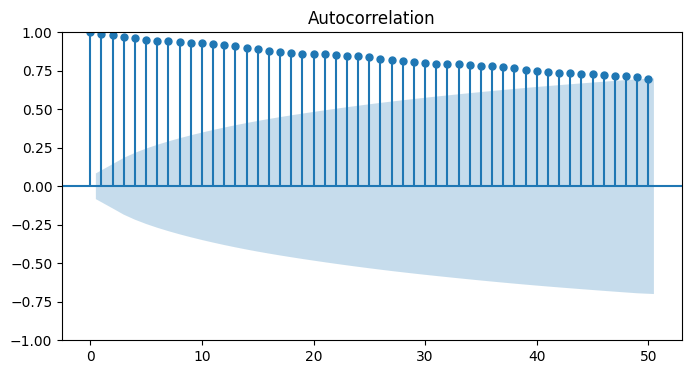

In [9]:

# 3. Gráfico de autocorrelação (FAC)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(data["valor"], lags=50, ax=ax)
plt.show()

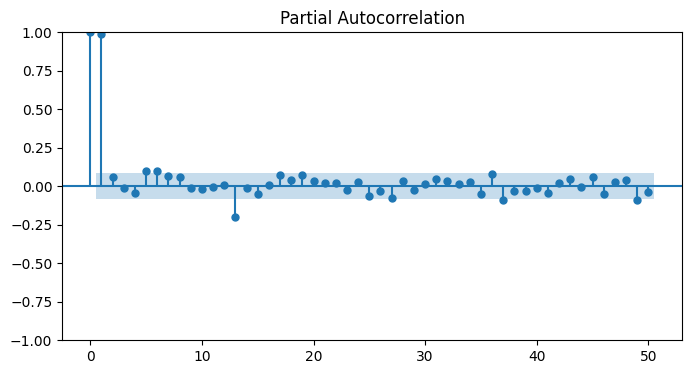

In [10]:
# 4. Gráfico de autocorrelação parcial (FACP)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_pacf(data["valor"], lags=50, ax=ax)
plt.show()


In [11]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Executar o Teste de Dickey-Fuller (ADF)
adf_test = adfuller(data["valor"])

adf_results = {
    "Estatística ADF": adf_test[0],
    "Valor-p": adf_test[1],
    "Nº de Lags": adf_test[2],
    "Nº de Observações": adf_test[3],
    "Valores Críticos": adf_test[4] 
}

adf_df = pd.DataFrame(adf_results.items(), columns=["Métrica", "Valor"])

adf_df

,Métrica,Valor
0,Estatística ADF,1.432084
1,Valor-p,0.997255
2,Nº de Lags,18
3,Nº de Observações,533
4,Valores Críticos,"{'1%': -3.442678467240966, '5%': -2.8669778698..."


In [12]:
adf_df[adf_df.Métrica == 'Valores Críticos'].values

array([['Valores Críticos',
        {'1%': -3.442678467240966, '5%': -2.8669778698997543, '10%': -2.5696661916864083}]],
      dtype=object)

## Continuação da Análise - Parte 2

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [14]:
# Carregar dados já carregados anteriormente como 'data'
# data contém colunas: 'data' e 'valor'

# Garantir que a coluna data seja do tipo datetime
data.index = pd.to_datetime(data.index)

In [15]:
# Removendo efeito calendário: Ajuste por dias úteis/mês
data['Dias_Uteis'] = data.index.days_in_month
data['Valor_ajustado'] = data['valor'] / data['Dias_Uteis'] * data['Dias_Uteis'].mean()

In [ ]:
# Testando transformações (log, potência, Box-Cox)
data['Valor_log'] = np.log(data['Valor_ajustado'])
# data['Valor_sqrt'] = np.sqrt(data['Valor_ajustado'])
data['Valor_boxcox'], lambda_bc = boxcox(data['Valor_ajustado'])

In [18]:
# Exemplo -- proseguir com Box-Cox

# Escolha a transformação com maior estabilidade de variância:
transformed_series = data['Valor_boxcox']

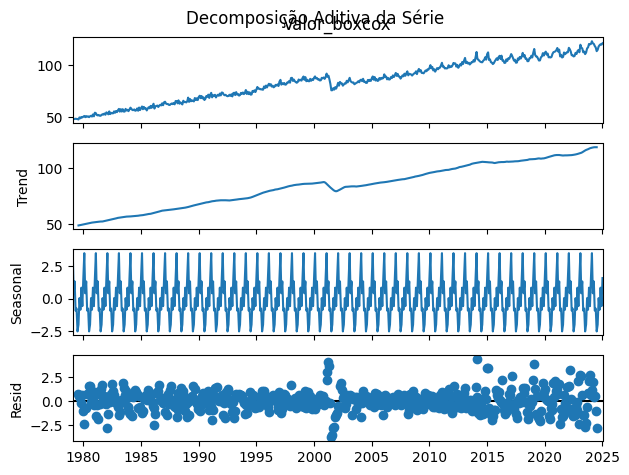

In [19]:
# Decomposição (geralmente multiplicativa se variância crescer com média)
decomposition = seasonal_decompose(transformed_series, model='additive', period=12)

decomposition.plot()
plt.suptitle('Decomposição Aditiva da Série')
plt.show()

In [20]:
# Remover a tendência (mantendo sazonalidade)
data['Sem_tendencia'] = transformed_series - decomposition.trend

In [ ]:
# Analisando sazonalidade por mês
sazonalidade = decomposition.seasonal.groupby(data.index.month).mean()

print("Estatísticas descritivas da sazonalidade mensal:")
print(sazonalidade.describe())

Estatísticas descritivas da sazonalidade mensal:
count    1.200000e+01
mean    -4.625929e-17
std      1.636018e+00
min     -2.495084e+00
25%     -8.667830e-01
50%     -2.713236e-01
75%      9.457105e-01
max      3.447474e+00
Name: seasonal, dtype: float64


In [23]:
# Remover sazonalidade
data['Sem_sazonalidade'] = data['Sem_tendencia'] - decomposition.seasonal

In [24]:
# Teste ADF após remoção de sazonalidade e tendência
adf_result = adfuller(data['Sem_sazonalidade'].dropna())

print("\nTeste ADF após ajustes")
print(f'Estatística ADF: {adf_result[0]}')
print(f'Valor-p: {adf_result[1]}')



Teste ADF após ajustes
Estatística ADF: -9.567733193208452
Valor-p: 2.3325570860500613e-16


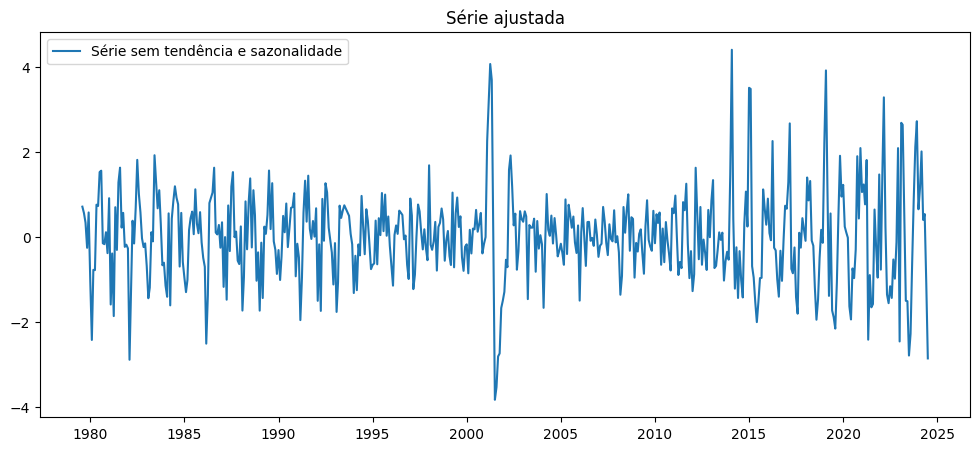

In [25]:
# Plot da série tratada
plt.figure(figsize=(12, 5))
plt.plot(data['Sem_sazonalidade'], label='Série sem tendência e sazonalidade')
plt.title('Série ajustada')
plt.legend()
plt.show()


In [ ]:
hhh